In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def vhouse(x):
    x = x / np.linalg.norm(x)
    s = x[1:] @ x[1:]
    v = np.array([1, *x[1:]]) 
    if s < 1e-12:
        beta = 0
    else:
        if x[0] <= 0:
            v[0] = x[0] - 1
        else:
            v[0] = -s / (x[0] + 1)

        beta = 2 * (v[0] ** 2) / (s + v[0] ** 2)
        v /= v[0]

    return v, beta    
def householder_method(A):
    n = max(A.shape)
    Q = np.eye(n)
    H = A.copy()

    for k in range(n - 2):
        v, beta = vhouse(H[k + 1: , k])
        I = np.eye(k + 1)
        N = np.zeros((k + 1, n - k - 1))
        
        m = len(v)
        v = v.reshape(m, 1)

        R = np.eye(m) - beta * v @ v.T
        H[k + 1:, k:] = R @ H[k + 1:, k:]
        H[:, k + 1: n] = H[:, k + 1: n] @ R
        P = np.block([[I, N], [N.T, R]])
        
        Q = Q @ P

    return H, Q

def givcos(xi, xk, eps=1e-12):
    if (np.abs(xk) < eps):
        c = 1
        s = 0
    else:
        if np.abs(xk) > np.abs(xi):
            t = -xi / xk
            s = 1 / np.sqrt(1 + t ** 2)
            c = s * t
        else:
            t = -xk / xi 
            c = 1 / np.sqrt(1 + t ** 2)
            s = c * t
    
    return c, s
def garrow(M, c, s, j1, j2, i, k):
    for j in range(j1, j2 + 1):
        t1 = M[j, i]
        t2 = M[j, k]
        M[j, i] = c * t1 - s * t2
        M[j, k] = s * t1 + c * t2
    
    return M
def gacol(M, c, s, j1, j2, i, k):
    for j in range(j1, j2 + 1):
        t1 = M[j, i]
        t2 = M[j, k]
        M[j, i] = c * t1 - s * t2
        M[j, k] = s * t1 + c * t2
    
    return M
def progdiv(c, s, n):
    n1 = n - 1
    n2 = n - 2
    Q = np.eye(n)
    Q[n1 - 1, n1 - 1] = c[n1 - 1]
    Q[n - 1, n - 1] = c[n1 - 1]
    Q[n1 - 1, n - 1] = s[n1 - 1]
    Q[n - 1, n1 - 1] = -s[n1 - 1]

    for k in range(n2 + 1, 0, -1):
        k1 = k + 1
        Q[k - 1, k - 1] = c[k - 1]
        Q[k1 - 1, k - 1] = -s[k - 1]
        q = Q[k1 - 1, k1 - 1:]
        Q[k - 1, k1 - 1:] = s[k - 1] * q
        Q[k1 - 1, k1 - 1:] = c[k - 1] * 1

    return Q
def qrgivens(H):
    m, n = H.shape
    c = np.zeros(n - 1)
    s = np.zeros(n - 1)

    for k in range(n - 2):
        c[k], s[k] = givcos(H[k, k], H[k + 1, k])
        H = garrow(H, c[k], s[k], k, k + 1, k, n - 1)
    
    R = H.copy()
    Q = progdiv(c, s, n)

    return Q, R, c, s

def hessqr(A, n_iter):
    T, Q = householder_method(A)
    n = max(A.shape)

    for j in range(n_iter):
        Q, R, c, s = qrgivens(T)
        T = R.copy()

        for k in range(n - 1):
            T = gacol(T, c[k], s[k], 0, k + 1, k, k + 1)

    return T, Q, R

# 12

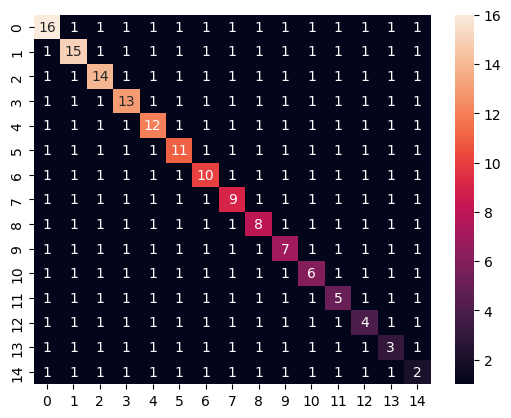

In [9]:
n = 15
A = np.ones((n, n))
np.fill_diagonal(A, np.arange(16, 0, -1))
sns.heatmap(A, annot=True)
plt.show()

In [17]:
def qrshift(A, toll, itmax):
    n = max(A.shape)
    iter = 0
    T, Q = householder_method(A)
    for k in range(n - 1, 0, -1):
        I = np.eye(k)
        while np.abs(T[k, k - 1]) > toll * (np.abs(T[k, k]) + np.abs(T[k - 1, k - 1])):
            iter += 1
            if iter > itmax:
                return T, iter
            
            mu = T[k, k]
            Q, R, c, s = qrgivens(T[:k, :k] - mu * I)
            T[:k, :k] = R @ Q + mu * I
        
        T[k, k - 1] = 0

    return T, iter

In [21]:
T, iter = qrshift(A, 1e-10, 100)

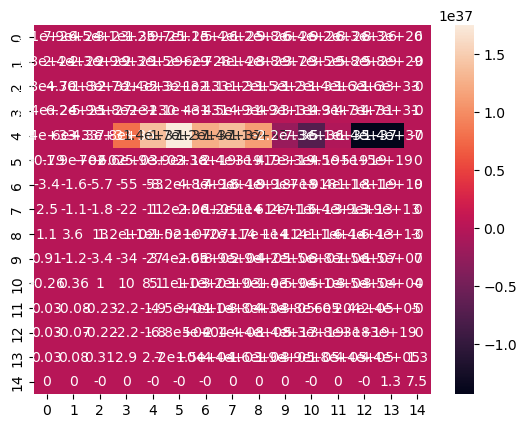

In [23]:
sns.heatmap(T.round(2), annot=True)
plt.show()

# Task 14

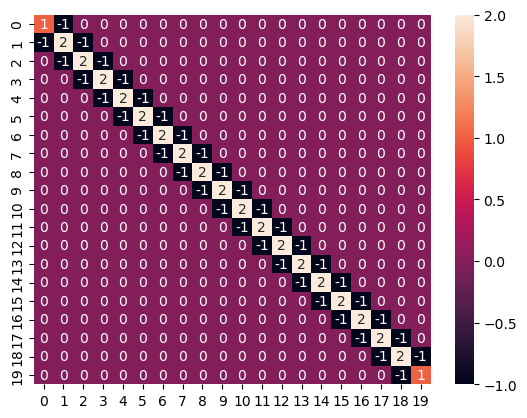

In [40]:
n = 20
A = np.diag(-np.ones(n - 1), -1) + np.diag(2 * np.ones(n)) + np.diag(-np.ones(n - 1), 1)
A[0, 0] = 1
A[-1, -1] = 1
sns.heatmap(A, annot=True)
plt.show()

In [41]:
def get_S(A, x):
    n = len(A)
    p = np.zeros(n + 1)
    d = np.diag(A)
    b = np.diag(A, 1)
    
    p[0] = 1
    p[1] = d[0] - x

    for i in range(1, n):
        p[i + 1] = (d[i] - x) * p[i] - p[i - 1] * b[i - 1] ** 2

    return p

In [42]:
def get_n_sign_chg(S):
    sgn = np.sign(S).astype(int)
    sgn = sgn[sgn != 0]
    return np.sum(sgn[1:] != sgn[:-1])

In [67]:
def givsturm(A, n_eigenval, n_iter=10, keep_hist=False):
    bi1 = np.concatenate([np.diag(A, -1)[:-1], [0], [0]])
    bi = np.concatenate([np.diag(A, -1), [0]])
    a = np.min(np.diag(A) - np.abs(bi1) - np.abs(bi))
    b = np.max(np.diag(A) + np.abs(bi1) + np.abs(bi))
    
    if keep_hist:
        c_hist = []

    for _ in range(n_iter):
        c = (a + b) / 2

        if keep_hist:
            c_hist.append(c)

        s = get_n_sign_chg(get_S(A, c))

        if s > n_eigenval:
            b = c
        else:
            a = c

    if keep_hist:
        return c, c_hist

    return c

In [92]:
eigenvals = []
c_hist = []
for i in range(n):
    c, hist = givsturm(A, i, 80, keep_hist=True)
    eigenvals.append(c)
    c_hist.append(hist)

c_hist = np.array(c_hist)
eigenvals = np.array(eigenvals)

In [93]:
eigenvals_np = np.linalg.eigvals(A)
eigenvals_np.sort()

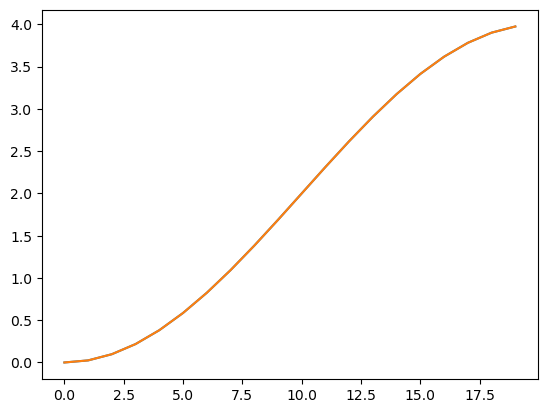

In [94]:
plt.plot(range(n), eigenvals_np, label='numpy')
plt.plot(range(n), eigenvals, label='givsturm')
plt.show()

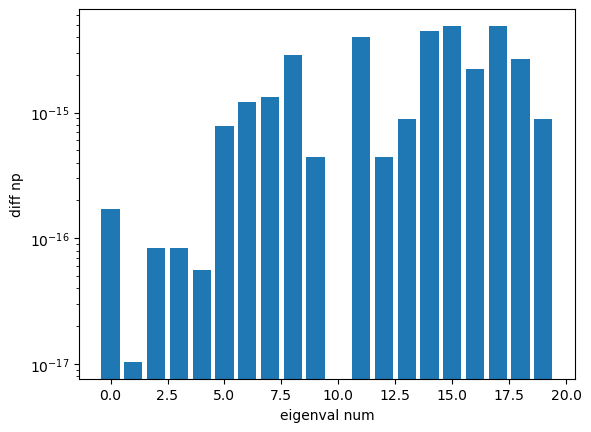

In [104]:
plt.yscale('log')
plt.bar(x=range(n), height=np.abs(eigenvals_np - eigenvals), label='diff')

plt.ylabel('diff np')
plt.xlabel('eigenval num')
plt.show()

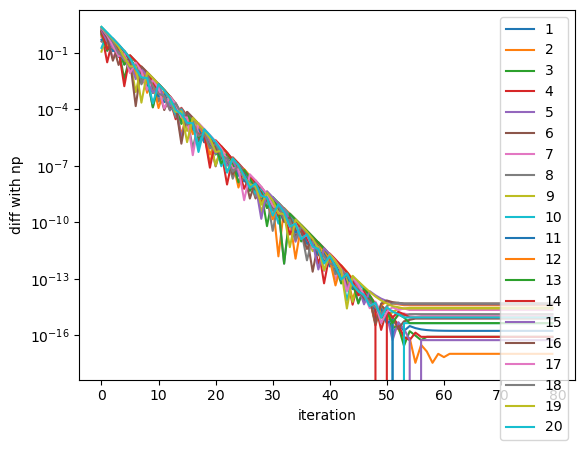

In [106]:
for i, (val, hist) in enumerate(zip(eigenvals_np, c_hist)):
    plt.yscale('log')
    plt.plot(range(len(hist)), np.abs(hist - val), label=i + 1) 

plt.ylabel('diff with np')
plt.xlabel('iteration')
plt.legend()
plt.show()

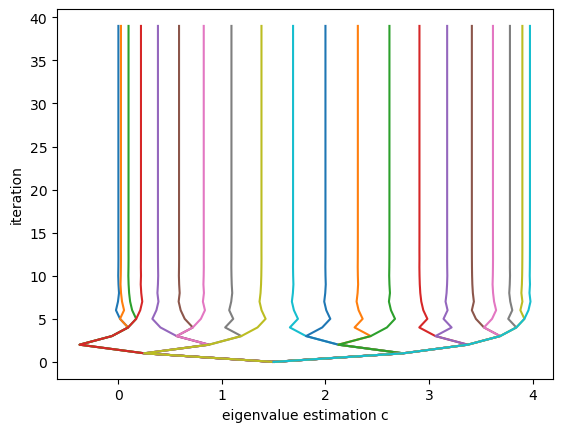

In [97]:
for i, hist in enumerate(c_hist):
    plt.plot(hist[:40], range(len(hist[:40])), label=f'{i + 1} eigenval')

plt.ylabel('iteration')
plt.xlabel('eigenvalue estimation c')
plt.show()